In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

# Load the MNIST dataset
(train_data, test_data), info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)

# Normalize the images to the range [0, 1]
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

train_data = train_data.map(normalize_img).batch(128).shuffle(10000)
test_data = test_data.map(normalize_img).batch(128)

# Function to add Gaussian noise to images
def add_noise(images, noise_factor=0.5):
    noise = noise_factor * tf.random.normal(shape=tf.shape(images))
    noisy_images = images + noise
    noisy_images = tf.clip_by_value(noisy_images, 0.0, 1.0)  # Clip to [0, 1]
    return noisy_images

# Adding noise to training and test datasets
train_data_noisy = train_data.map(lambda x, y: (add_noise(x), x))
test_data_noisy = test_data.map(lambda x, y: (add_noise(x), x))


In [4]:
from tensorflow.keras import layers, models

# Define the encoder
def build_encoder(input_shape):
    encoder_input = tf.keras.Input(shape=input_shape)
    x = layers.Flatten()(encoder_input)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    encoder_output = layers.Dense(32, activation='relu')(x)
    return models.Model(encoder_input, encoder_output, name="encoder")

# Define the decoder
def build_decoder(encoder_output_shape):
    decoder_input = tf.keras.Input(shape=(encoder_output_shape,))
    x = layers.Dense(64, activation='relu')(decoder_input)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(28 * 28, activation='sigmoid')(x)
    decoder_output = layers.Reshape((28, 28))(x)
    return models.Model(decoder_input, decoder_output, name="decoder")

# Build the autoencoder
input_shape = (28, 28)
encoder = build_encoder(input_shape)
decoder = build_decoder(encoder.output_shape[-1])

autoencoder = models.Model(encoder.input, decoder(encoder.output), name="autoencoder")

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 28, 28)              │         111,568 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 222,384 (868.69 KB)

 Trainable params: 222,384 (868.69 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Train the autoencoder
history = autoencoder.fit(train_data_noisy, epochs=10, validation_data=test_data_noisy)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.0772 - val_loss: 0.0367
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0353 - val_loss: 0.0305
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0299 - val_loss: 0.0270
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0270 - val_loss: 0.0251
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0252 - val_loss: 0.0238
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0240 - val_loss: 0.0228
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0230 - val_loss: 0.0219
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0222 - val_loss: 0.0213
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0215 - val_loss: 0.0207
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0209 - val_loss: 0.0201


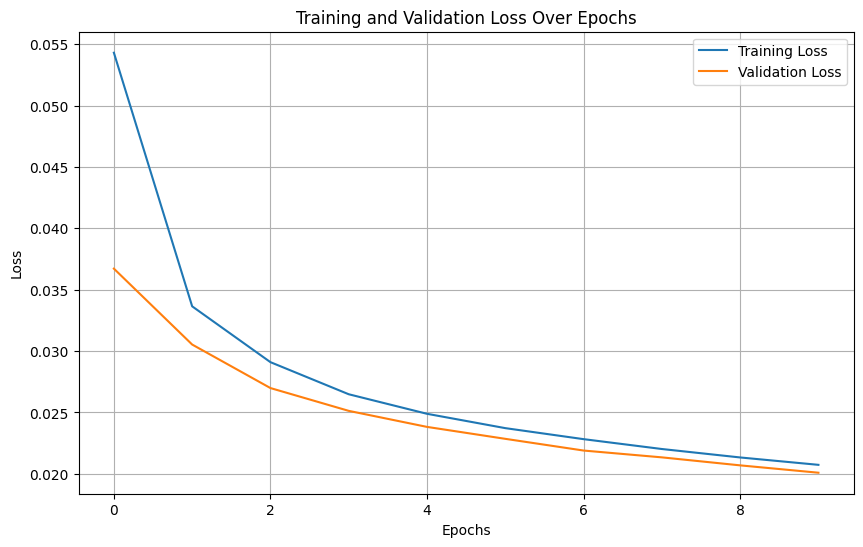

In [8]:
import matplotlib.pyplot as plt

# Plot the training loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


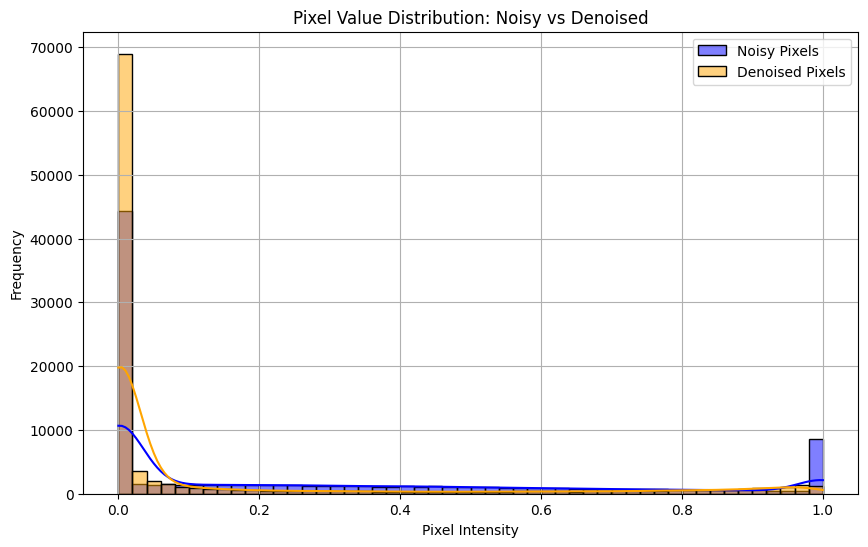

In [11]:
import seaborn as sns
# Compare the pixel value distributions
def plot_pixel_distribution(noisy_images, denoised_images):
    noisy_flat = noisy_images.numpy().flatten()
    denoised_flat = denoised_images.flatten()

    plt.figure(figsize=(10, 6))
    sns.histplot(noisy_flat, color="blue", kde=True, label="Noisy Pixels", bins=50)
    sns.histplot(denoised_flat, color="orange", kde=True, label="Denoised Pixels", bins=50)
    plt.title('Pixel Value Distribution: Noisy vs Denoised')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the distributions
plot_pixel_distribution(noisy_images, denoised_images)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


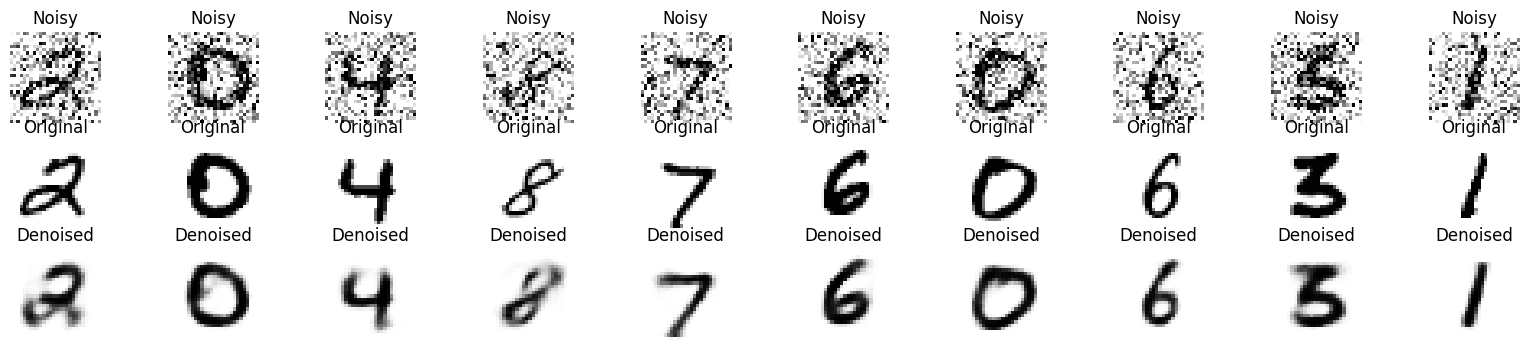

In [7]:
import matplotlib.pyplot as plt

# Function to display images
def display_images(noisy, clean, denoised, num_images=10):
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Convert tensors to numpy arrays and reshape
        noisy_image = noisy[i].numpy().reshape(28, 28)
        clean_image = clean[i].numpy().reshape(28, 28)
        denoised_image = denoised[i].reshape(28, 28)

        # Display noisy images
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(noisy_image, cmap="binary")
        plt.title("Noisy")
        plt.axis("off")

        # Display original clean images
        ax = plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(clean_image, cmap="binary")
        plt.title("Original")
        plt.axis("off")

        # Display denoised images
        ax = plt.subplot(3, num_images, i + 1 + num_images * 2)
        plt.imshow(denoised_image, cmap="binary")
        plt.title("Denoised")
        plt.axis("off")
    plt.show()

# Get a batch of test images
test_images = next(iter(test_data_noisy))
noisy_images, clean_images = test_images

# Predict the denoised images
denoised_images = autoencoder.predict(noisy_images)

# Display the results
display_images(noisy_images, clean_images, denoised_images)
